# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Gabriel Tornare, Kilian Meier, Jérôme Savary  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

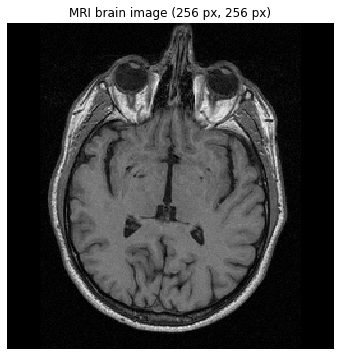

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


### 1.2 Region growing
#### Algorithm
The process can be described by the following steps:
1. Denoise the image using a median filter
2. Create a marker image with one region for the background and one for the brain
3. Grow the regions from the markers using the watershed algorithm on the original image
4. Count the number of pixel labeled as "brain"
5. Display the results

#### Discussion
This method lead to intersting results despite the fact that some regions which are behind the eyes are also considered as brain. Morevover the interstitial space between brain and skull tends to be considered as brain as well since the watersheding will stop aingst the skull. 
Another big drawback of this method is the dependance on the initial brain marker. Which, when modified, can lead to very different segmentation.

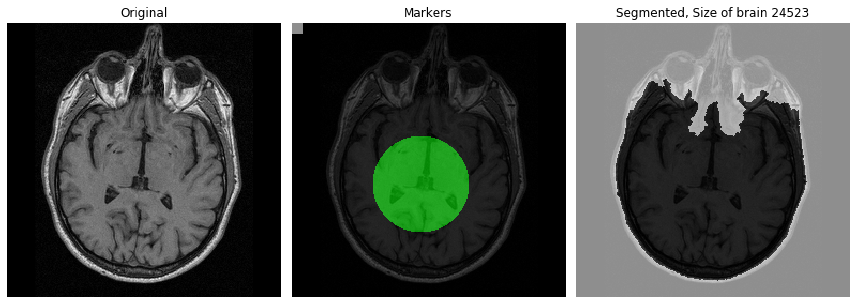

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.draw import rectangle
from skimage.draw import circle
from skimage.filters import rank

labelBrain = 1
labelBackground = 2

# denoise image
denoised = rank.median(brain_im, disk(1))
image = np.copy(brain_im)

# define markers for wateshed
# one small rectagle to define background
# a circle that approximates the brain
circle_rad = 45

markers = np.zeros_like(denoised)
rr, cc = circle(150,120,radius=circle_rad, shape=markers.shape)
markers[rr,cc] = labelBrain
rr, cc = rectangle((0,0), extent=(10,10), shape=markers.shape)
markers[rr,cc] = labelBackground

# perform the watershed
labels = watershed(image, markers)

# count number of pixel labeled as brain
brain_size = np.sum(labels==labelBrain)


# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[1].set_title("Markers")

ax[2].imshow(image, cmap=plt.cm.gray)
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[2].set_title("Segmented, Size of brain {}".format(brain_size))

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### 1.3 Contour detection (gradient)
#### Algorithm
The process can be described by the following steps:
1. Denoise the image using a median filter
2. Create a marker image with one region for the background and one for the brain
3. Compute the local gradient of the image 
4. Grow the regions from the markers using the watershed algorithm on the local gradient image
5. Count the number of pixel labeled as "brain"
6. Display the results

#### Discussion
This method lead to interesting results despite the fact that some regions which are behind the eyes are also considered as brain and some region close to the nose that should be are not. Morevover, as for region growing, the interstitial space between brain and skull tends to be considered as brain as well since the gradient does result in wide edges. 
However this method is much more robust to the definition of the initial brain marker. 

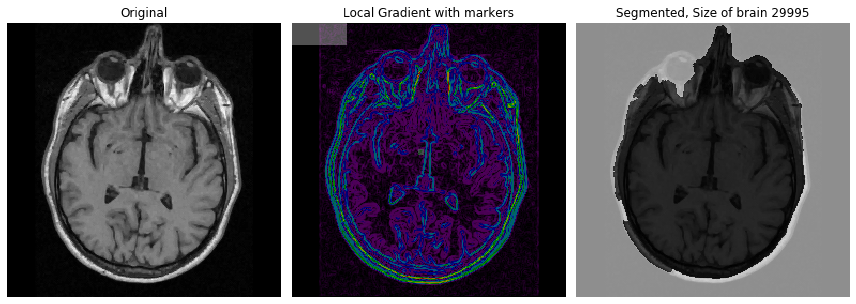

In [8]:
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import filters
from skimage.draw import rectangle
from skimage.draw import circle

labelBrain = 1
labelBackground = 2

# denoise image
denoised = rank.median(brain_im, disk(1))

# computing sobel edges
edge_sobel = filters.sobel(denoised)

image = denoised
gradient = edge_sobel

# define markers for wateshed
# one small rectagle to define background
# a circle that approximates the brain
radius = 3
extent = (20,50)
circ_row = 120
circ_col = 120

markers = np.zeros_like(image)
rr, cc = circle(circ_row,circ_col,radius, shape=markers.shape)
markers[rr,cc] = labelBrain
rr, cc = rectangle((0,0), extent, shape=markers.shape)
markers[rr,cc] = labelBackground

# perform the watershed
labels = watershed(gradient, markers)

# count number of pixel labeled as brain
brain_size = np.sum(labels==labelBrain)


# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=.4)
ax[1].set_title("Local Gradient with markers")

ax[2].imshow(image, cmap=plt.cm.gray)
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[2].set_title("Segmented, Size of brain {}".format(brain_size))



for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### 1.3 bis Contour detection (sobel)
#### Algorithm
The process can be described by the following steps:
1. Denoise the image using a median filter
2. Create a marker image with one region for the background and one for the brain
3. Detect edges using a Sobel filter
4. Grow the regions from the markers using the watershed algorithm on the detected edges
5. Count the number of pixel labeled as "brain"
6. Display the results

#### Discussion
This method leads to very similar results as the gradient contour detection. The main difference is that the edges are smoother with the sobel contour detection.

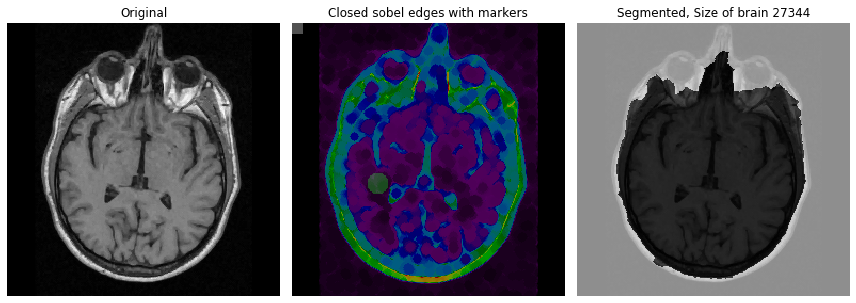

In [9]:
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.morphology import closing
from skimage.segmentation import watershed
from skimage import filters
from skimage.draw import rectangle
from skimage.draw import circle

labelBrain = 1
labelBackground = 2

# denoise image
denoised = rank.median(brain_im, disk(1))

# compute sobel edges
edge_sobel = filters.sobel(denoised)
edge_sobel = closing(edge_sobel,disk(4))


# define markers for wateshed
# one small rectagle to define background
# a circle that approximates the brain
markers = np.zeros_like(image)
rr, cc = circle(150,80,radius=10, shape=markers.shape)
markers[rr,cc] = labelBrain
rr, cc = rectangle((0,0), extent=(10,10), shape=markers.shape)
markers[rr,cc] = labelBackground

# perform the watershed
labels = watershed(edge_sobel, markers)

# count number of pixel labeled as brain
brain_size = np.sum(labels==labelBrain)


# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(edge_sobel, cmap=plt.cm.nipy_spectral)
ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=.4)
ax[1].set_title("Closed sobel edges with markers")

ax[2].imshow(image, cmap=plt.cm.gray)
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.7)
ax[2].set_title("Segmented, Size of brain {}".format(brain_size))



for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### 1.4 Thresholding
#### Algorithm
The process can be described by the following steps:
1. Compute the image histogram
2. Define thresholds for the brain pixels (here done empirically)
3. Mask out pixels outside of this interval
4. Perform opening and a closing
5. Count the number of pixel labeled as "brain"
6. Display the results

#### Discussion
This method leads to the least precise results. This is mainly due to skull and brain pixels being very close in color. Moreover the opening and closing do not preserve the edges, and the size of the structural element has a big impact on the final brain size, which make them very arbitrary.

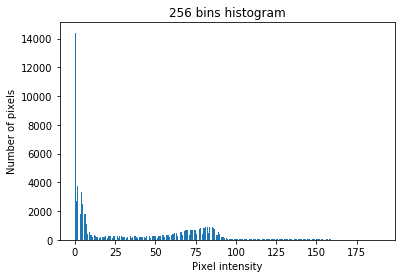

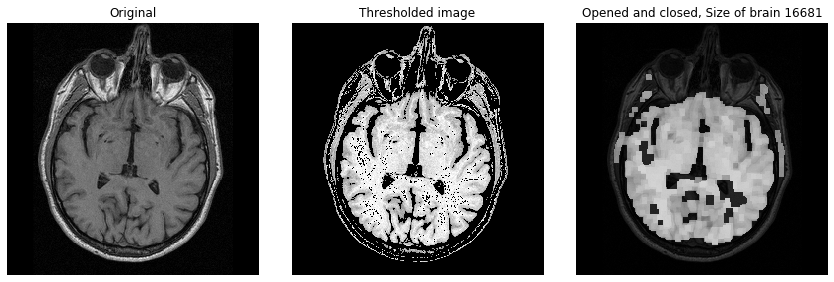

In [10]:
import numpy as np
from skimage.morphology import closing
from skimage.morphology import opening
from skimage.morphology import rectangle

nb_bins = 256

# Display histogram
plt.figure(figsize=(6, 4))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

mask_b = brain_im[:,:] < 50
mask_w = brain_im[:,:] > 90
brain_masked = np.copy(brain_im)
brain_masked[mask_b] = 0
brain_masked[mask_w] = 0


brain_morph = opening(brain_masked,rectangle(5,5))
brain_morph = closing(brain_morph,rectangle(5,5))

# count number of pixel labeled as brain
brain_size = np.sum(brain_morph>0)


# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title("Original")


ax[1].imshow(brain_masked,cmap=plt.cm.gray)
ax[1].set_title("Thresholded image")

ax[2].imshow(brain_im, cmap=plt.cm.gray)
ax[2].imshow(brain_morph, cmap=plt.cm.gray, alpha=.7)
ax[2].set_title("Opened and closed, Size of brain {}".format(brain_size))



for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


### 1.4 bis thresholding (bis)
#### Algorithm
The process can be described by the following steps:
1. Apply a filter to segregate the pixels whose values are between two threshold values
2. Delete all segregated areas whose size is under a determined theshold ("open the image")
3. Close the image to delete the black areas inside the brain shape which are smaller than an arbitrary threshold ("close the image")
4. Count the number of pixel labeled as "brain"
5. Display the results

#### Discussion
This method lead to interesting results for only the brain white area is bigger than the given threshold. Step one of the algorithm allows to separate the brain from all other white areas of the skull and skin, and we can justify the thresholds by being the gray range at which the brain emits when visualised by MRI. The output is relatively clean and precise.

finished thresholding


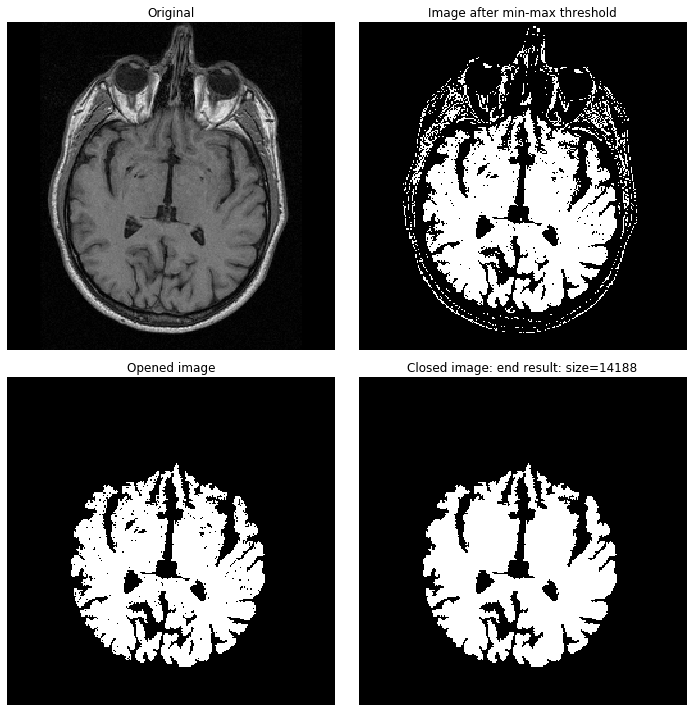

In [11]:
import numpy as np
import sys

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
thresh_min = 65
thresh_max = 95
counter = 0
thresh_im = np.zeros((im_h, im_w))

for i in np.arange(im_h):
    for j in np.arange(im_w):
        if (brain_im[i][j] > thresh_min and brain_im[i][j] < thresh_max):
            thresh_im[i][j] = 1
        else:
            thresh_im[i][j] = 0
        
print("finished thresholding")

#closing the image
from skimage.morphology import area_closing
from skimage.morphology import area_opening

min_white_area = 300
min_black_area = 100
#connectivity can either be 1 (4 neighbours) or 2 (8 neighbours)
connectivity = 1
opened_im = area_opening(thresh_im, min_white_area, connectivity=1, parent=None, tree_traverser=None)

closed_im = area_closing(opened_im, min_black_area, connectivity=1, parent=None, tree_traverser=None)

#count number of remaining white pixels
brain_pix_size = np.sum(closed_im==labelBrain)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(thresh_im, cmap=plt.cm.gray)
ax[1].set_title("Image after min-max threshold")

ax[2].imshow(opened_im, cmap=plt.cm.gray)
ax[2].set_title("Opened image")

ax[3].imshow(closed_im, cmap=plt.cm.gray)
ax[3].set_title('Closed image: end result: size={}'.format(brain_pix_size))

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [12]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


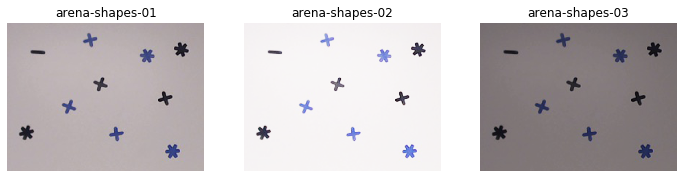

In [13]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
#### Algorithm 
The process can be described by the following steps:
1. Convert image to gray scale
2. Denoise the image using a median filter
3. Find background by thresholding and use remaing pixels as markers
4. Perform watersheding on sobel edges of original image
5. Computing mean color and size of each object
6. Compute separation threshold
7. Classify objects and compute number of object and area per class
8. Display the results

#### Discussion
This approach leads to good results : all the objects are correctly calssified and well delimited. However it relies on several assumption. First one the background threshold definition relies on the fact the background is dominant in the image (taking the mean of the image), this is ok while the objects are sparse in the image and the background is homogene. This could be solved by using other background removal approach, here an active contour might be an intersting solution. Second, the classification between objects relies on the fact that there are around the same number of objects in each class (mean of the mean color), this can be solved by using other classification approaches such as k-means for example.
This approach uses only grayscale images, but one could maybe benefit from the color information to create a more robust algorithm, maybe changing color space and using one of those dimensions could be intersting. 
Finally, one could question the use of the watersheding since the markers computed are already pretty good object segmentations, but watersheding adds probably some robustness and could lead to better edges depending on the contrast of the original image.

Nbr of black objects 5 total area 5708, nbr of blue objects 5 total area 5829


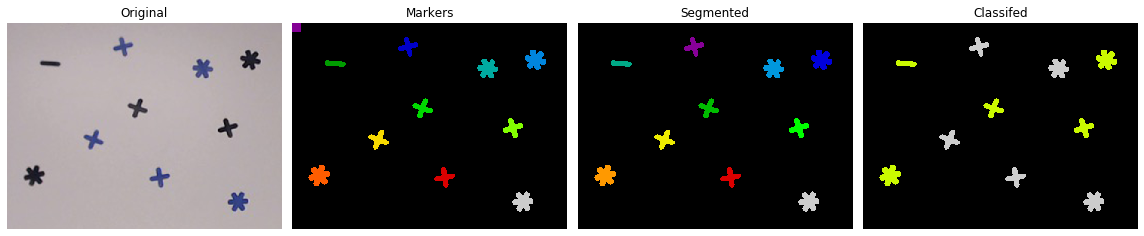

Nbr of black objects 5 total area 5133, nbr of blue objects 5 total area 5156


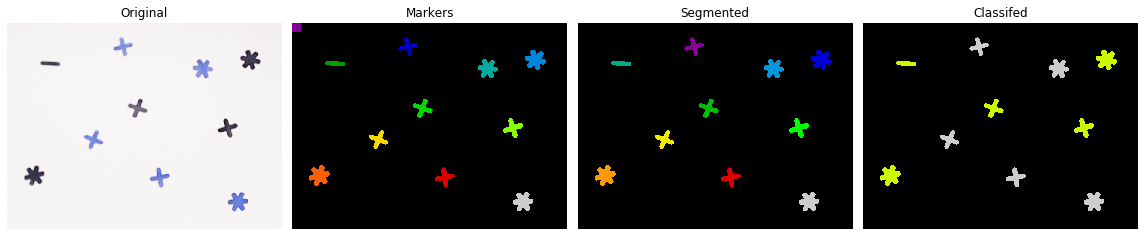

Nbr of black objects 5 total area 5507, nbr of blue objects 5 total area 5616


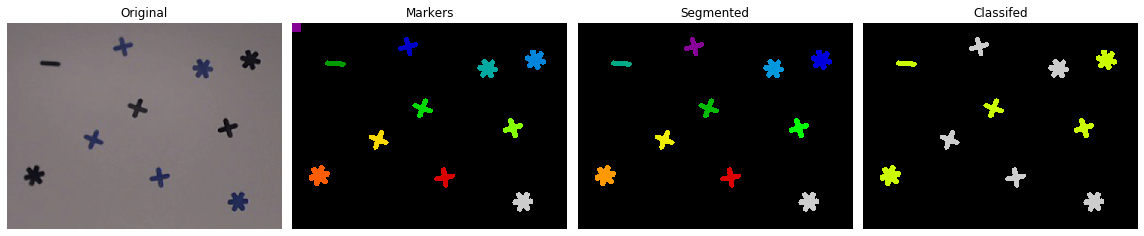

In [203]:
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.draw import rectangle
from skimage.draw import circle
from skimage.measure import label
from skimage.color import rgb2gray
from skimage.morphology import erosion


for im in images :
    # convert to grayscale
    im_gray = rgb2gray(im)

    # denoise image
    denoised = rank.median(im_gray, disk(1))

    # define markers for wateshed
    # one small rectagle to define background
    # and markers where there is no background
    # background is defined as an interval around the mean color of the image
    markers = np.zeros_like(im_gray)
    thresh = np.average(im_gray)
    interval = 0.1
    markers[im_gray<thresh-interval] = 1
    markers[im_gray>thresh+interval] = 1
    rr, cc = rectangle((0,0), extent=(20,20), shape=markers.shape)
    markers[rr,cc] = 1    
    markers = label(markers)

    
    # sobel edges
    edge_sobel = filters.sobel(denoised)

    # perform the watershed
    labels = watershed(edge_sobel, markers)    
    
    # computing mean color and size of each object
    objMean = {}
    objSize = {}
    for i in range(2,np.max(labels)+1) :
        objMean[i] = np.average(im_gray[labels==i])
        objSize[i] = np.sum(labels==i)
    
    # calculating a speration threshold to classify the mean color of the object
    # the threshold is defined as the average of the all mean colors
    sep = np.average(list(objMean.values()))
    
    # classifying objects by comparing them to the treshold
    # creating an image with the classified objects
    # counting the object in each class
    # adding up the total area of each color 
    nbrBlue = 0
    nbrBlack = 0
    areaBlue = 0
    areaBlack = 0
    res = np.zeros_like(im_gray)
    
    for obj in objMean :
        if objMean[obj] > sep :
            nbrBlue = nbrBlue + 1
            areaBlue = areaBlue + objSize[obj]
            res[labels==obj] = 3
        else :
            nbrBlack = nbrBlack + 1
            areaBlack = areaBlack + objSize[obj]
            res[labels==obj] = 2
    

    # display results
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 8),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im)
    ax[0].set_title("Original")


    ax[1].imshow(markers, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[1].set_title("Markers")

    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[2].set_title("Segmented")
    
    ax[3].imshow(res, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[3].set_title("Classifed")
    
    print("Nbr of black objects {} total area {}, nbr of blue objects {} total area {}".format(nbrBlack,areaBlack,nbrBlue,areaBlue))

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

C:\Users\etaxi\Miniconda2\envs\iapr2020\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


Nbr of black objects 5708 total area 5, nbr of blue objects 5829 total area 5


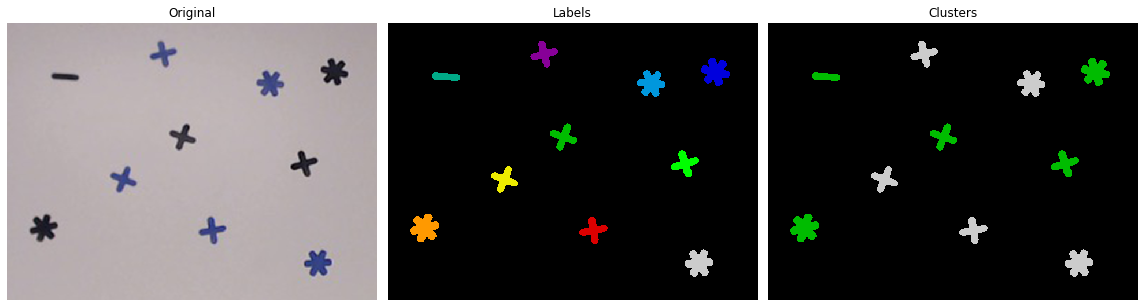

C:\Users\etaxi\Miniconda2\envs\iapr2020\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


Nbr of black objects 5133 total area 5, nbr of blue objects 5156 total area 5


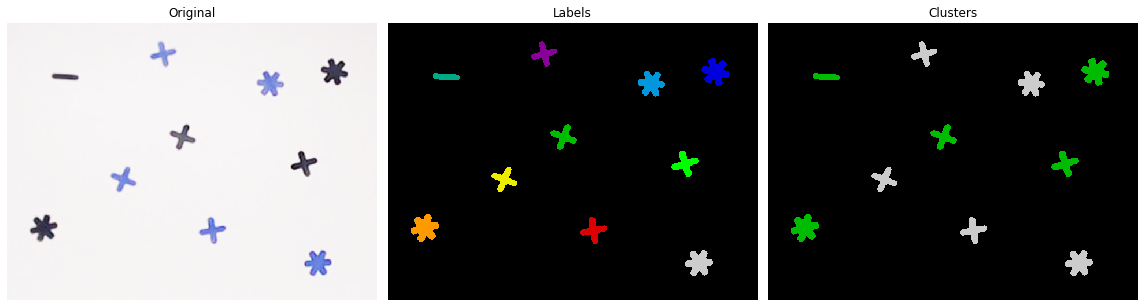

C:\Users\etaxi\Miniconda2\envs\iapr2020\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


Nbr of black objects 5507 total area 5, nbr of blue objects 5616 total area 5


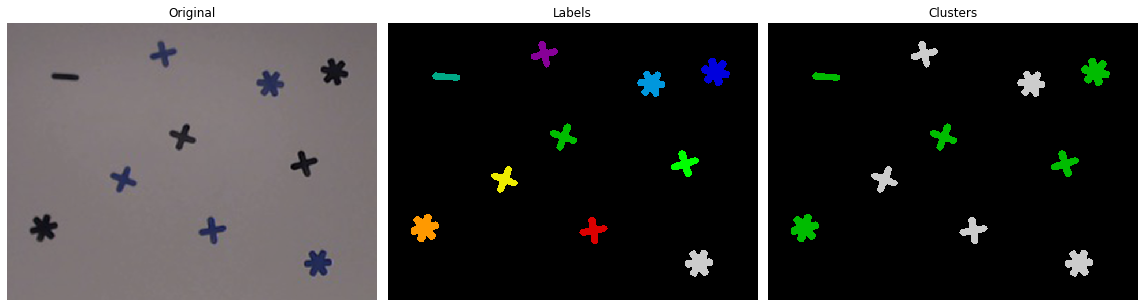

In [200]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

for im in images: #for each image
    # convert to grayscale
    im_gray = rgb2gray(im)

    # denoise image
    denoised = rank.median(im_gray, disk(1))

    # define markers for wateshed
    # one small rectagle to define background
    # and markers where there is no background
    # background is defined as an interval around the mean color of the image
    markers = np.zeros_like(im_gray)
    thresh = np.average(im_gray)
    interval = 0.1
    markers[im_gray<thresh-interval] = 1
    markers[im_gray>thresh+interval] = 1
    rr, cc = rectangle((0,0), extent=(20,20), shape=markers.shape)
    markers[rr,cc] = 1    
    markers = label(markers)

    # sobel edges
    edge_sobel = filters.sobel(denoised)

    # perform the watershed
    labels = watershed(edge_sobel, markers) 
    
    # perform clustering 
    nb_obj = np.max(labels)-1
    X = np.zeros( (nb_obj, 1))
    for i in np.arange(nb_obj):  #Compute the mean color in each object, this feature is enough to cluster our objects ! 
        X[i] = np.mean(im[labels==i+2]) #Note : labels[i,j]=1 means background, so the first object is at labels[i,j]=2

    kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 600, n_init = 10, random_state =0)
    pred_y = kmeans.fit_predict(X)
    pred_y+=1 #to not have the 0 label (the prediction is therefore 1 or 2)

    cluster_labels = np.zeros(labels.shape)
    for i in np.arange(nb_obj):
        cluster_labels[labels==i+2] = pred_y[i]
    
    # display results
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8),sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(im)
    ax[0].set_title("Original")

    ax[1].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[1].set_title("Labels")

    ax[2].imshow(cluster_labels, cmap=plt.cm.nipy_spectral, alpha=1)
    ax[2].set_title("Clusters")
    
    print("Nbr of black objects {} total area {}, nbr of blue objects {} total area {}".format(
          np.sum(cluster_labels==1),np.sum(pred_y==1),np.sum(cluster_labels==2),np.sum(pred_y==2)))
    
    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

### 2.3 Total area (in pixels) of each color
This was already realized in the previous question.